## Training UNet3D network for tumor detection in MR images using Brats 2018 data.
The notebook is an attempt to train a network to segment tumors from MR brain images. The paper that is being attempted here is 
https://arxiv.org/pdf/1802.10508.pdf . The current implementation has been guided by the preprocessing and patching logic from https://github.com/ellisdg/3DUnetCNN for fastestimator environment.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastestimator.dataset import brats
import pandas as pd
import nibabel as nib
import os
from nilearn import plotting
import numpy as np
import fastestimator as fe
from fastestimator.architecture import UNet3D_Isensee
from fastestimator.op import TensorOp, NumpyOp
from fastestimator.op.numpyop import ImageReader, NIBImageReader
from fastestimator.trace import LRController, ModelSaver
from fastestimator.op.tensorop.augmentation import Augmentation3D
from fastestimator.op.tensorop import Loss, ModelOp
from fastestimator.op.tensorop.loss import BinaryCrossentropy, WeightedDiceLoss
import tensorflow as tf

### Please follow the link to download  https://www.med.upenn.edu/sbia/brats2018/data.html. One has to register at the site.
Having downloaded the Brats 2018 dataset , created folder structure
   <br> ~/fastestimator_data/Brats 
   <br> ~/fastestimator_data/BraTs/data
   <br> ~/fastestimator_data/BraTs/data/LGG
   <br> ~/fastestimator_data/BraTs/data/HGG 


### Let visualize the BraTs 2018 data we are dealing with. 
Shall be reading nifti image pertaining to  t1 modality as well as the segmentation ground truth using the nibable package. Nilearn plotting are utilized to display mask and image overlay.

In [3]:
path_brats = os.path.join(os.getenv('HOME'),'fastestimator_data/BraTs/')

In [4]:
image_nifti = nib.load(os.path.join(path_brats,'data','LGG', 'Brats18_TCIA10_490_1', 'Brats18_TCIA10_490_1_t1.nii.gz'))
mask_nifti = nib.load(os.path.join(path_brats,'data','LGG', 'Brats18_TCIA10_490_1', 'Brats18_TCIA10_490_1_seg.nii.gz'))

Plotting the t1 image

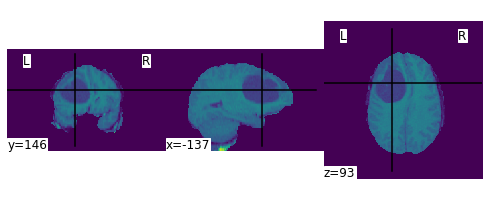

In [5]:
plotting.plot_img(image_nifti, [-137,146,93])

Plotting the t1 image with segmentation mask as overlay

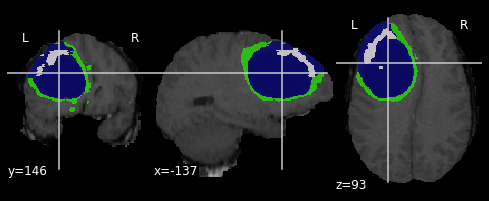

In [6]:
plotting.plot_roi(mask_nifti, image_nifti)

### There are few things going on here in the below step when we invoke the brats.load_data to generate csv.
-  Brats 2018 typical data sample is in the following format :<br>
!ls ~/fastestimator_data/BraTs/data/LGG/Brats18_TCIA10_490_1/<br>
The following are MR t1, t2, t1ce and flair images<br>
Brats18_TCIA10_490_1_flair.nii.gz<br>
Brats18_TCIA10_490_1_t1ce.nii.gz<br>
Brats18_TCIA10_490_1_t2.nii.gz<br>
Brats18_TCIA10_490_1_t1.nii.gz<br>

The following is the segementation ground truth, it has 3 labels (1,2,4) for representing edema, enhancing tumor core, necrotic tumor core. 
Brats18_TCIA10_490_1_seg.nii.gz   

The 'image' column consists of samples which are of dimension 4x240x240x155. '4' represents the 4 types of MR images listed above. 
The 'mask' column consists of samples which are of dimension  240x240x155. 

'image' samples are run through simple itk's N4BiasFieldCorrection as it is standard step for bias correction.<br>
'image' samples are cropped to non-zero regions. This step is carried out for 'mask' samples as well.<br>
'image' samples are reordered to RAS. 'mask' samples are reordered to RAS space as well.
'image' samples are resampled to new size having equal height,width,depth. This step is carried out for 'mask' samples  as well.<br>
Mean and std are calculated across the BraTs 2018 distribution.<br>
'image' samples are processed with (x-mean)/std  step.<br>



In [7]:
train_csv, val_csv, path = brats.load_data(path_brats=os.path.join(os.getenv('HOME'),'fastestimator_data/BraTs/'), 
                                               resized_img_shape=(128,128,128), bias_correction=True)

In [8]:
df =pd.read_csv(train_csv)
df.head()

,mod_img,seg_mask
0,/home/ubuntu/fastestimator_data/BraTs/preproce...,/home/ubuntu/fastestimator_data/BraTs/preproce...
1,/home/ubuntu/fastestimator_data/BraTs/preproce...,/home/ubuntu/fastestimator_data/BraTs/preproce...
2,/home/ubuntu/fastestimator_data/BraTs/preproce...,/home/ubuntu/fastestimator_data/BraTs/preproce...
3,/home/ubuntu/fastestimator_data/BraTs/preproce...,/home/ubuntu/fastestimator_data/BraTs/preproce...
4,/home/ubuntu/fastestimator_data/BraTs/preproce...,/home/ubuntu/fastestimator_data/BraTs/preproce...


### Displaying the above sample, after the preprocess step.

In [9]:
image_pre_nifti = nib.load( os.path.join(path_brats,'preprocessed', 'Brats18_TCIA10_490_1_mod.nii.gz'))
mask_pre_nifti = nib.load(os.path.join(path_brats,'preprocessed', 'Brats18_TCIA10_490_1_seg.nii.gz'))
affine = image_pre_nifti.affine
image_pre_t1_nifti = nib.Nifti1Image(image_pre_nifti.get_data()[0], affine=affine)   
affine = mask_pre_nifti.affine
mask_pre_t1_nifti = nib.Nifti1Image(mask_pre_nifti.get_data()[0], affine=affine)

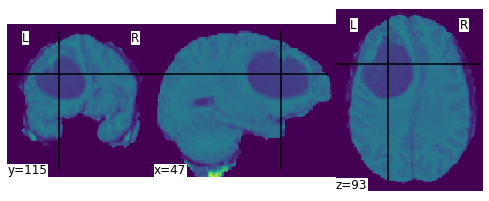

In [11]:
plotting.plot_img(image_pre_t1_nifti, [47,115, 93])

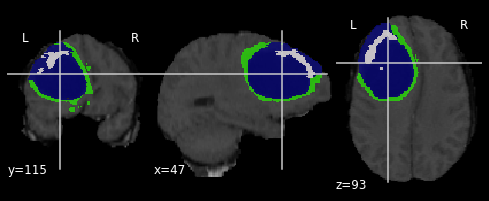

In [10]:
plotting.plot_roi(mask_pre_t1_nifti, image_pre_t1_nifti)

### RecordWriter Step
Reads the train csv and validation csv having nifti image paths.<br>
RecordWriter leverages NIBImageReader class to read nifti images.<br>


In [13]:
writer = fe.RecordWriter(
        save_dir=os.path.join(path_brats, "tfrecords"),
        train_data= train_csv,
        validation_data= val_csv,
        ops=[
            NIBImageReader(inputs="mod_img", outputs=["mod_img", "affine"]),
            NIBImageReader(inputs="seg_mask", outputs=["seg_mask", "seg_affine"])
        ],
        compression="GZIP",
        write_feature=[
            'mod_img','affine','seg_mask'
        ])

### Pipeline Operations
RandomImagePatches generates  3D patches from the Image and Mask. The patch size is defined by patch_shape.<br>
The 'mask' samples are of dimension nxnxn ,  'mask' are translated into 3xnxnxn , one for each label i.e. for edema, enhancing tumor core, necrotic tumor core.

In [14]:
class RandomImagePatches(TensorOp):
    def __init__(self, inputs=None, outputs=None, mode=None, image_shape=(144,144,144),patch_shape=(64,64,64),
                 patch_start_offset=16):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.nlabels = 3
        self.labels = [1,2,4]
        self.image_shape = tf.constant(image_shape, dtype=tf.dtypes.int32)
        self.patch_start_offset = tf.constant(patch_start_offset, dtype=tf.dtypes.int32)
        self.patch_shape = tf.constant( patch_shape, dtype=tf.dtypes.int32)
        self.modality_images, self.seg_mask = None, None
        
        
    def handle_padding_case(self, patch):
        pad_before = tf.where(patch < 0 , tf.abs(patch),0)
        pad_after = tf.where( (patch+ self.patch_shape) > self.image_shape, 
                             tf.abs( (patch + self.patch_shape) - self.image_shape), 0)
        padding = tf.stack( [pad_before, pad_after] , axis=1)
        no_padding = [[0,0]] # no padding in the batch dimension and the next dimention 
        padding = tf.concat([no_padding, padding], axis=0)
        data_pad = tf.pad(self.modality_images, padding, mode='CONSTANT', constant_values=0)
        truth_pad = tf.pad(self.segmask_multi_class, padding, mode='CONSTANT', constant_values=0)
        patch = patch + pad_before   
        data_patch = data_pad[..., patch[0]:patch[0]+self.patch_shape[0], patch[1]:patch[1]+self.patch_shape[1],
            patch[2]:patch[2]+self.patch_shape[2]]
        truth_patch = truth_pad[..., patch[0]:patch[0]+self.patch_shape[0], patch[1]:patch[1]+self.patch_shape[1],
           patch[2]:patch[2]+self.patch_shape[2]]
        return data_patch, truth_patch
            
    def handle_nopaddding_case(self, patch):
        data_pad = self.modality_images
        truth_pad = self.segmask_multi_class
        data_patch = data_pad[..., patch[0]:patch[0]+self.patch_shape[0], patch[1]:patch[1]+self.patch_shape[1],
            patch[2]:patch[2]+self.patch_shape[2]]
        truth_patch = truth_pad[..., patch[0]:patch[0]+self.patch_shape[0], patch[1]:patch[1]+self.patch_shape[1],
            patch[2]:patch[2]+self.patch_shape[2]]
        return data_patch, truth_patch
            
    def get_image_patch(self, patch):
        cond1 = tf.reduce_any(patch < 0 )
        cond2 = tf.reduce_any( patch + self.patch_shape > self.image_shape)
        cond = tf.logical_or(cond1,cond2)
        data_patch, truth_patch = tf.cond(cond,lambda: self.handle_padding_case(patch), 
                                          lambda:self.handle_nopaddding_case(patch))
        return data_patch, truth_patch
        
    def forward(self, data, state):
        self.modality_images, self.seg_mask = data
        new_shape = [self.nlabels]+ list(self.seg_mask.shape[-3:])

        cls_1 = tf.where(self.seg_mask[0]==self.labels[0],1,0)
        cls_2 = tf.where(self.seg_mask[0]==self.labels[1],1,0)
        cls_4 = tf.where(self.seg_mask[0]==self.labels[2],1,0)
        self.segmask_multi_class = tf.stack([cls_1,cls_2,cls_4])
        
        # We randomly select the start of patches 
        random_start_offset = tf.negative(tf.random.uniform(shape=(3,),minval=0,maxval=self.patch_start_offset+1, 
                                                            dtype=tf.dtypes.int32))

        start = random_start_offset
        stop = self.image_shape + random_start_offset
        step = self.patch_shape
        x,y,z = tf.meshgrid( tf.range(start[0],stop[0],step[0]),  tf.range(start[1],stop[1],step[1]), 
                                        tf.range(start[2],stop[2],step[2]),indexing='ij')
        patches = tf.stack([x,y,z],axis=0)
        patches = tf.transpose(tf.reshape(patches,(3,-1)))
        
        data_stack,truth_stack = tf.map_fn(self.get_image_patch,patches, 
                                           dtype=(tf.dtypes.float32, tf.dtypes.int32), back_prop=False)
        mask = tf.map_fn(lambda tr: tf.reduce_any(tf.not_equal(tr,0)) , truth_stack, 
                 dtype=tf.bool, back_prop=False)
        data_stack = tf.boolean_mask(data_stack, mask)
        truth_stack = tf.boolean_mask(truth_stack, mask)  

        return data_stack, truth_stack
    

### Pipeline engages Augmentation3D operation. 
The patches have equal height, width and depth, here we utilize various isometries of a cube for augmentation.
https://en.wikipedia.org/wiki/Octahedral_symmetry#The_isometries_of_the_cube

Segmentation mask consits of 3 labels ['1','2','4']. This class splits the mask into 3 masks having one type of label each.

In [15]:
class SplitMaskLabelwise(TensorOp):
    def __init__(self, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.nlabels = 3
        self.labels = [1,2,4]
    def forward(self, data, state):
        seg_mask = data
        cls_1 = tf.where(seg_mask[0]==self.labels[0],1,0)
        cls_2 = tf.where(seg_mask[0]==self.labels[1],1,0)
        cls_4 = tf.where(seg_mask[0]==self.labels[2],1,0)
        segmask_multi_label = tf.stack([cls_1,cls_2,cls_4])
        return segmask_multi_label

    
pipeline = fe.Pipeline(data=writer,
                        batch_size=1,
                        ops=[ SplitMaskLabelwise(inputs="seg_mask", outputs="seg_mask") ,
                        Augmentation3D(inputs=("mod_img","seg_mask"), outputs=("mod_img", "seg_mask"), mode='train')])
        

In a memory constrained enviroment, one may choose to go for the image patches rather than the whole image. RandomImagePatches helps one generate patches defined by patch_shape for both 'image' and 'mask'        


In [111]:
# pipeline = fe.Pipeline(data=writer,
#                        batch_size=2,
#                        ops=[Augmentation3D(inputs=("mod_img","seg_mask"), outputs=("mod_img", "seg_mask")) , 
#                            RandomImagePatches(inputs=("mod_img", "seg_mask"), outputs=("mod_img", "seg_mask"),
#                                 image_shape=(128,128,128),patch_shape=(64,64,64),patch_start_offset=0)],
#                        expand_dims=True)

### Generating batches from pipeline api show_results.

In [17]:
sample_batch = pipeline.show_results()

FastEstimator: Reading non-empty directory: /home/ubuntu/fastestimator_data/BraTs/tfrecords
FastEstimator: Found 228 examples for train in /home/ubuntu/fastestimator_data/BraTs/tfrecords/train_summary0.json
FastEstimator: Found 57 examples for eval in /home/ubuntu/fastestimator_data/BraTs/tfrecords/eval_summary0.json


###  View the 'image' and 'mask' sample after all the processing in the pipeline stage.

In [18]:
image_prep_aug = sample_batch[0]['mod_img'][0]
image_prep_aug = image_prep_aug.numpy()

mask_prep_aug = sample_batch[0]['seg_mask'][0]
mask_prep_aug = mask_prep_aug.numpy()

affine = sample_batch[0]['affine'][0]
affine = affine.numpy()

image_patch = nib.Nifti1Image(image_prep_aug[0], affine=affine)
mask_patch = nib.Nifti1Image(mask_prep_aug[2], affine=affine)

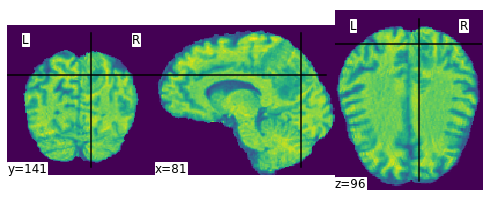

In [20]:
plotting.plot_img(image_patch, [81, 141, 96])

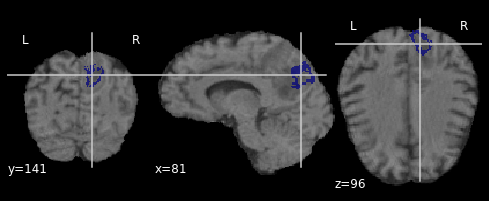

In [21]:
plotting.plot_roi(mask_patch, image_patch)

### Proposed  Network from https://arxiv.org/pdf/1802.10508.pdf

![network](./Figure/Isensee_network.jpeg)

### Creation of the network.

In [22]:
model_unet3d_is = fe.build(model_def=lambda: UNet3D_Isensee(input_shape=(4, 128,128, 128)),
                         model_name="brats_unet3d_is",
                         optimizer=tf.optimizers.Adam(learning_rate=5e-4),
                         loss_name="wdice_loss")


network = fe.Network(ops=[
    ModelOp(inputs="mod_img", model=model_unet3d_is, outputs="pred_seg_mask"),
    WeightedDiceLoss(inputs=("seg_mask", "pred_seg_mask"),
               outputs=("wdice_loss"))])

### Creation of the estimator.

In [23]:
# prepare estimator
model_dir = path_brats
estimator = fe.Estimator(
    network=network,
    pipeline=pipeline,
    steps_per_epoch= 228,
    epochs=500,
    traces=[ModelSaver(model_name="brats_unet3d_is", save_dir=model_dir, save_best=True),
           LRController(model_name="brats_unet3d_is",reduce_patience=10, reduce_factor=0.5, 
                        reduce_on_eval=True, min_lr=1e-07)],
    log_steps=228)

### Training begins ...

In [24]:
estimator.fit()

### Inference
BraTs inference:
Prediction of a sample of dimension (4x128x128x128) yields prediction mask of dimension (3x128x128x128).
Prediction mask is translated into single channel having labels 1,2,4 reducing the prediction mask to 128x128x128.

'whole tumor' area is the combination of  labels 1,2 and 4.<br>
'tumor core' area is the combination of labels 1 and 4.<br> 
'enhancing tumor' area is repsented by label 4.<br>

The dice score of 'whole tumor' and 'tumor core' and 'enhancing core' of models is contested in BraTs competition.<br> 

In [30]:
model_unet3d_is.load_weights(os.path.join(os.getenv('HOME'),'fastestimator_data/BraTs/brats_unet3d_is_best_wdice_loss.h5'))

validation_batches = pipeline.show_results(mode='eval', num_steps=57)

In [ ]:
def single_channel_mask(mask):
    thres = 0.5
    mask_shape = mask.shape
    mask_all_labels = np.zeros(shape= mask_shape[1:], dtype=np.int)

    max_probs = np.max(mask, axis=0)
    max_args = np.argmax(mask, axis=0)

    mask_all_labels[ max_args==0]=1
    mask_all_labels[ max_args==1]=2
    mask_all_labels[ max_args==2]=4
    mask_all_labels[ max_probs < thres] = 0
    return mask_all_labels
    
def dice_coeff(truth, prediction):
    return (2 * np.sum(truth * prediction)+1)/(np.sum(truth) + np.sum(prediction)+1)

#### Dice score for 'whole tumor', 'tumor core' and 'enhancing tumor' on validaiton data.

In [75]:
dice_coeff_wt = []    # whole tumor
dice_coeff_tc = []    # tumor core
dice_coeff_et = []    # enhancing tumor
for validation_batch in validation_batches:
    batch_prediction_mask = model_unet3d_is(validation_batch['mod_img'])
    for mod_img, seg_mask, prediction_mask in zip(validation_batch['mod_img'], 
                                                  validation_batch['seg_mask'], batch_prediction_mask):
        
        seg_mask = seg_mask.numpy()
        prediction_mask = prediction_mask.numpy()
        prediction_mask = single_channel_mask(prediction_mask)
        seg_mask = single_channel_mask(seg_mask)
        prediction_mask_wt = prediction_mask > 0  #  wt for whole tumor
        seg_mask_wt = seg_mask > 0
        prediction_mask_tc = np.any([prediction_mask==1,prediction_mask==4], axis=0)  # tc for tumor core
        seg_mask_tc = np.any([seg_mask==1 , seg_mask==4], axis=0)
        prediction_mask_et  = prediction_mask==4    # et for enhancing tumor
        seg_mask_et = seg_mask==4
        dice_coeff_wt.append( dice_coeff(seg_mask_wt, prediction_mask_wt))
        dice_coeff_tc.append( dice_coeff(seg_mask_tc, prediction_mask_tc))
        dice_coeff_et.append( dice_coeff(seg_mask_et, prediction_mask_et))

print('dice_coeff_whole_tumor:', np.mean(dice_coeff_wt))
print('dice_coeff_tumor_core:', np.mean(dice_coeff_tc))
print('dice_coeff_enhancing_tumor:', np.mean(dice_coeff_et))

### Visualize  prediction mask  in comparison with ground truth segmentation mask.

In [69]:

validation_batch = validation_batches[np.random.choice(range(57))]
mod_img = validation_batch['mod_img']
mod_elem_img = mod_img.numpy()[0]   

batch_pred_mask = model_unet3d_is(mod_img)  # prediction
elem_pred_mask = batch_pred_mask.numpy()[0]
elem_pred_mask = single_channel_mask(elem_pred_mask)

batch_truth_mask = validation_batch['seg_mask']
elem_truth_mask = batch_truth_mask.numpy()[0]
elem_truth_mask = single_channel_mask(elem_truth_mask)

affine = validation_batch['affine'][0]
affine = affine.numpy()

In [70]:
nifti_val_img = nib.Nifti1Image(mod_elem_img[0], affine=affine) # index 0 indicate t1 modality has been selected for background
                                                                #  ["t1", "t1ce", "flair", "t2"]

In [71]:
nifti_pred_img = nib.Nifti1Image(elem_pred_mask, affine=affine)
nifti_truth_img = nib.Nifti1Image(elem_truth_mask, affine=affine)

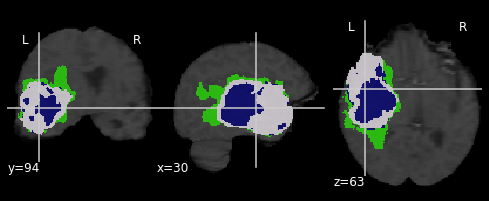

In [74]:
plotting.plot_roi(nifti_truth_img, nifti_val_img, cut_coords=[30, 94, 63])

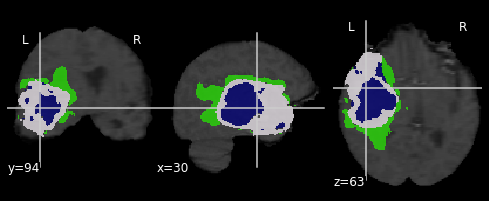

In [73]:
plotting.plot_roi(nifti_pred_img, nifti_val_img)